# Forecasting Exercises
This exercise uses a  time series of California Hospitality Industry Employees.

<div class="alert alert-danger" style="margin: 10px"><strong>IMPORTANT NOTE!</strong> Make sure you don't run the cells directly above the example output shown, <br>otherwise you will end up writing over the example output!</div>

In [2]:
# RUN THIS CELL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load datasets
df = pd.read_csv('HospitalityEmployees.csv',index_col='Date',parse_dates=True)
df.index.freq = 'MS'
print(len(df))
print(df.head())

348
            Employees
Date                 
1990-01-01     1064.5
1990-02-01     1074.5
1990-03-01     1090.0
1990-04-01     1097.4
1990-05-01     1108.7


So <tt>df</tt> has 348 records and one column. The data represents the number of employees in thousands of persons as monthly averages from January, 1990 to December 2018.

### 1. Plot the source data
Create a line chart of the dataset. Optional: add a title and y-axis label.

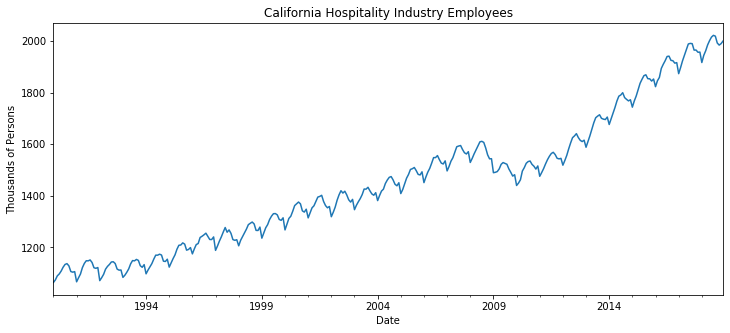

In [4]:
## CODE HERE
df.plot(figsize=(12,5), title='California Hospitality Industry Employees', legend=False);
plt.ylabel('Thousands of Persons');

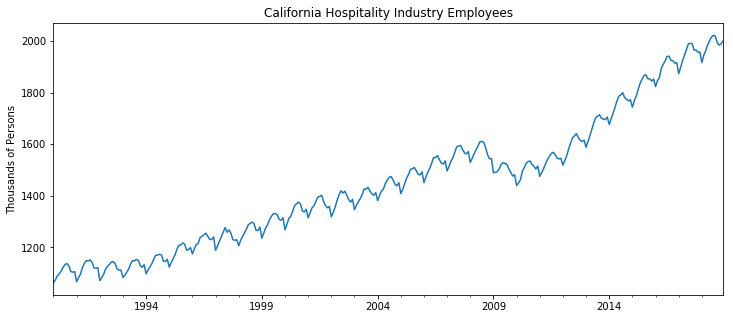

In [2]:
# DON'T WRITE HERE

### 2. Run an ETS Decomposition
Use an 'additive' model.

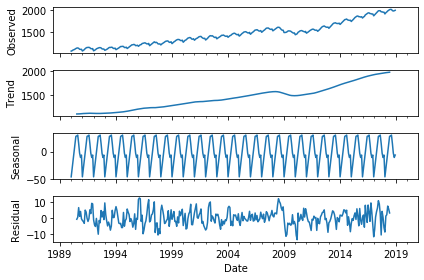

In [5]:
decomposition = seasonal_decompose(df, freq=12)
fig = decomposition.plot();
fig.set_size_inches(6, 4);
plt.xlim('1988-06-30', '2020-12-31');

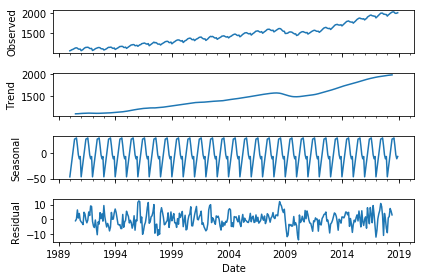

In [3]:
# DON'T WRITE HERE

### 3. Test to see if the data is currently stationary. If not transform the data to make it more stationary.  




In [6]:
from statsmodels.tsa.stattools import adfuller

#create a function that will help us to quickly 
def test_stationarity(timeseries, window):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

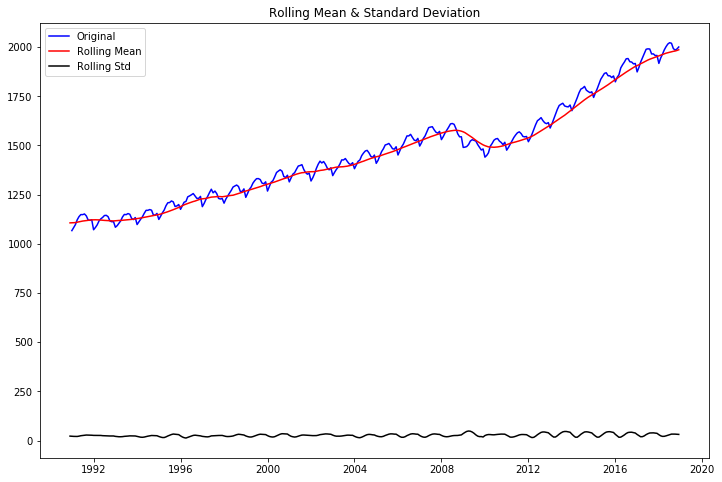

Results of Dickey-Fuller Test:
Test Statistic                   0.901284
p-value                          0.993107
#Lags Used                      17.000000
Number of Observations Used    330.000000
Critical Value (1%)             -3.450322
Critical Value (5%)             -2.870338
Critical Value (10%)            -2.571458
dtype: float64


In [7]:
test_stationarity(df['Employees'], 12)

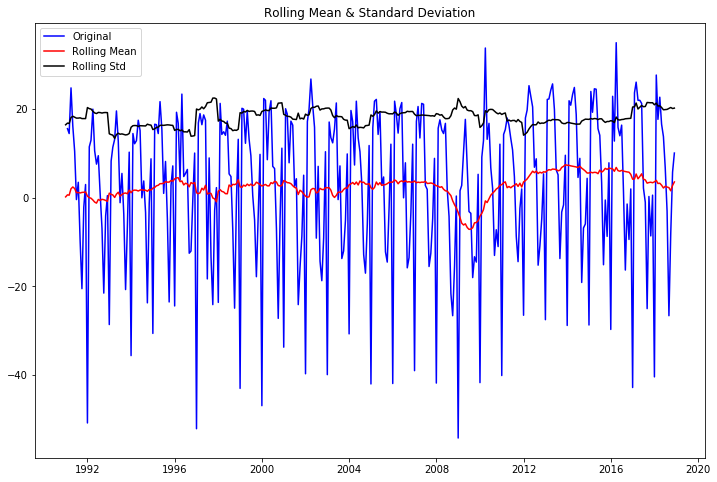

Results of Dickey-Fuller Test:
Test Statistic                  -3.068279
p-value                          0.028992
#Lags Used                      17.000000
Number of Observations Used    329.000000
Critical Value (1%)             -3.450384
Critical Value (5%)             -2.870365
Critical Value (10%)            -2.571472
dtype: float64


In [8]:
df['first_difference'] = df['Employees'] - df['Employees'].shift(1)  
test_stationarity(df['first_difference'].dropna(inplace=False),12)

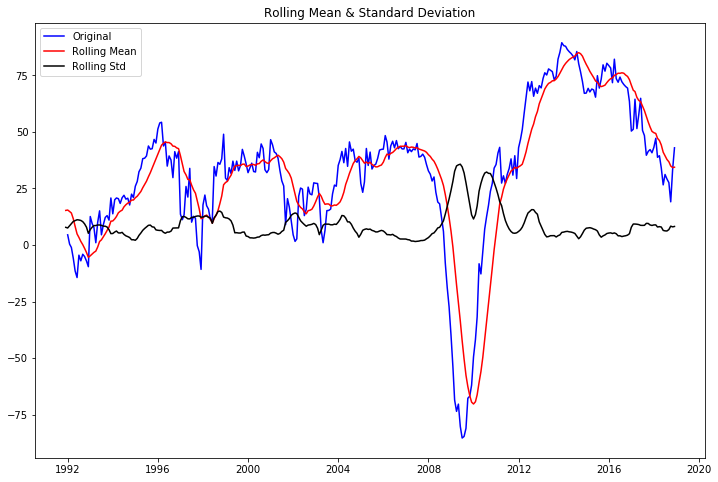

Results of Dickey-Fuller Test:
Test Statistic                  -2.570485
p-value                          0.099252
#Lags Used                      15.000000
Number of Observations Used    320.000000
Critical Value (1%)             -3.450952
Critical Value (5%)             -2.870615
Critical Value (10%)            -2.571605
dtype: float64


In [9]:
df['seasonal_difference'] = df['Employees'] - df['Employees'].shift(12)  
test_stationarity(df['seasonal_difference'].dropna(inplace=False),12)

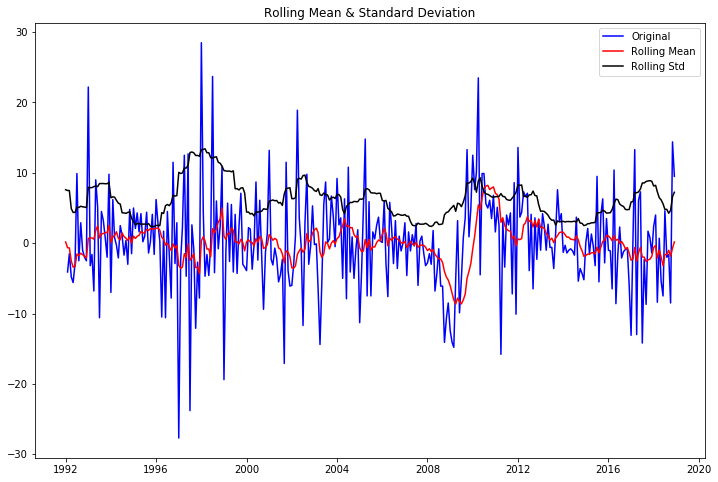

Results of Dickey-Fuller Test:
Test Statistic                -6.555191e+00
p-value                        8.651806e-09
#Lags Used                     1.100000e+01
Number of Observations Used    3.230000e+02
Critical Value (1%)           -3.450759e+00
Critical Value (5%)           -2.870530e+00
Critical Value (10%)          -2.571560e+00
dtype: float64


In [10]:
df['seasonal_first_difference'] = df['first_difference'] - df['first_difference'].shift(12)  
test_stationarity(df['seasonal_first_difference'].dropna(inplace=False),12)

In [11]:
df.head()

,Employees,first_difference,seasonal_difference,seasonal_first_difference
Date,,,,
1990-01-01,1064.5,NaN,NaN,NaN
1990-02-01,1074.5,10.0,NaN,NaN
1990-03-01,1090.0,15.5,NaN,NaN
1990-04-01,1097.4,7.4,NaN,NaN
1990-05-01,1108.7,11.3,NaN,NaN



### 4. Graph the ACF and PACF plots of your stationary data to determine the possible parameters for the ARIMA or SARIMA model.

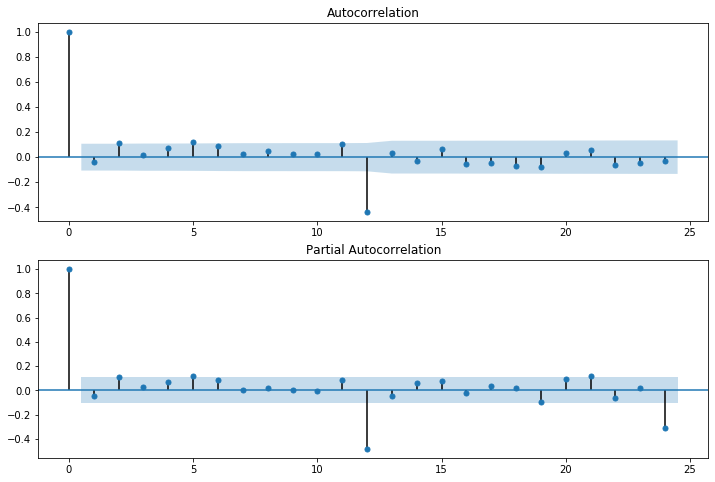

In [12]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(df['seasonal_first_difference'].iloc[13:], lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(df['seasonal_first_difference'].iloc[13:], lags=24, ax=ax2)

In [13]:
# write your ideal parameters here.
p = 0
d = 1
q = 0

P = 0
D = 1
Q = 0

### 5. Run <tt>pmdarima.auto_arima</tt> to obtain recommended orders
This may take awhile as there are a lot of combinations to evaluate.

In [14]:
auto_arima(df['Employees'], seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  348
Model:             SARIMAX(1, 1, 2)x(1, 0, 1, 12)   Log Likelihood               -1098.298
Date:                            Fri, 20 Dec 2019   AIC                           2210.595
Time:                                    10:36:24   BIC                           2237.541
Sample:                                         0   HQIC                          2221.324
                                            - 348                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.005      0.069      0.945      -0.010       0.011
ar.L1          0.9222      0.046     20.204      0.000       0.833       1.012
ma.L1         -0.9444      0.071    -13.357      0.000      -1.083      -0.806
ma.L2          0.1352      0.060      2.251      0.024       0.017       0.253
ar.S.L12       0.9976      0.001    703.429      0.000       0.995       1.000
ma.S.L12      -0.7567      0.042    -17.834      0.000      -0.840      -0.674
sigma2        29.2616      1.707     17.145      0.000      25.916      32.607
===================================================================================
Ljung-Box (Q):                       32.08   Jarque-Bera (JB):                66.68
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                            -0.09
Prob(H) (two-sided):                  0.44   Kurtosis:                         5.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [4]:
# DON'T WRITE HERE

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  348
Model:             SARIMAX(0, 1, 0)x(2, 0, 0, 12)   Log Likelihood               -1134.664
Date:                            Wed, 27 Mar 2019   AIC                           2277.328
Time:                                    13:12:10   BIC                           2292.726
Sample:                                         0   HQIC                          2283.459
                                            - 348                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0477      0.292     -0.163      0.870      -0.620       0.524
ar.S.L12       0.5291      0.040     13.286      0.000       0.451       0.607
ar.S.L24       0.4303      0.041     10.453      0.000       0.350       0.511
sigma2        37.2952      2.157     17.294      0.000      33.068      41.522
===================================================================================
Ljung-Box (Q):                       99.53   Jarque-Bera (JB):                51.67
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.29
Prob(H) (two-sided):                  0.42   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

You should see a recommended ARIMA Order of (0,1,0) combined with a seasonal order of (2,0,0,12).
### 6. Split the data into train/test sets
Set one year (12 records) for testing. There is more than one way to do this!

In [15]:
df.shape

(348, 4)

In [16]:
df.head()

,Employees,first_difference,seasonal_difference,seasonal_first_difference
Date,,,,
1990-01-01,1064.5,NaN,NaN,NaN
1990-02-01,1074.5,10.0,NaN,NaN
1990-03-01,1090.0,15.5,NaN,NaN
1990-04-01,1097.4,7.4,NaN,NaN
1990-05-01,1108.7,11.3,NaN,NaN


In [19]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [15]:
train = df['Employees'].iloc[:-12]
test = df['Employees'].iloc[-12:]

In [5]:
# DON'T WRITE HERE

### 7. Fit a SARIMA(0,1,0)(2,0,0,12) model to the training set

In [16]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(1, 1, 2),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          Employees   No. Observations:                  336
Model:             SARIMAX(1, 1, 2)x(1, 0, 1, 12)   Log Likelihood                -995.968
Date:                            Thu, 19 Dec 2019   AIC                           2003.937
Time:                                    17:01:56   BIC                           2026.547
Sample:                                01-01-1990   HQIC                          2012.965
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9237      0.043     21.489      0.000       0.839       1.008
ma.L1         -0.9715      0.072   

In [6]:
# DON'T WRITE HERE

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          Employees   No. Observations:                  336
Model:             SARIMAX(0, 1, 0)x(2, 0, 0, 12)   Log Likelihood               -1095.407
Date:                            Wed, 27 Mar 2019   AIC                           2196.814
Time:                                    13:12:24   BIC                           2208.256
Sample:                                01-01-1990   HQIC                          2201.375
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.5204      0.040     13.051      0.000       0.442       0.599
ar.S.L24       0.4385      0.041     10.593      0.000       0.357       0.520
sigma2        37.1907      2.165     17.175      0.000      32.947      41.435
===================================================================================
Ljung-Box (Q):                      102.80   Jarque-Bera (JB):                56.66
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -0.35
Prob(H) (two-sided):                  0.74   Kurtosis:                         4.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 8. Obtain predicted values

In [17]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,1,2)(1,0,1,12) Predictions')

In [7]:
# DON'T WRITE HERE

### 9. Plot predictions against known values
Optional: add a title and y-axis label.

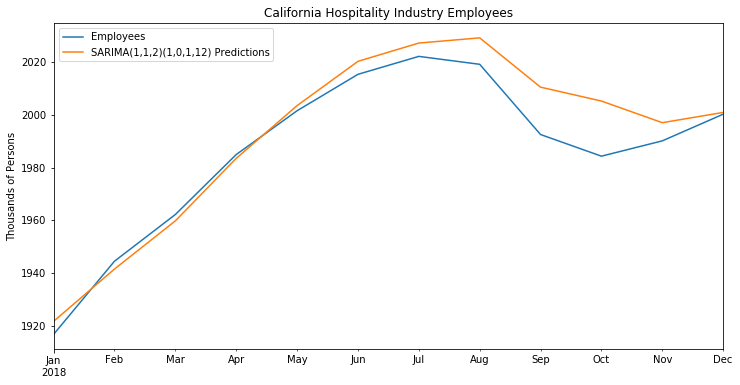

In [18]:
# Plot predictions against known values
title = 'California Hospitality Industry Employees'
ylabel='Thousands of Persons'
xlabel=''

ax = test.plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

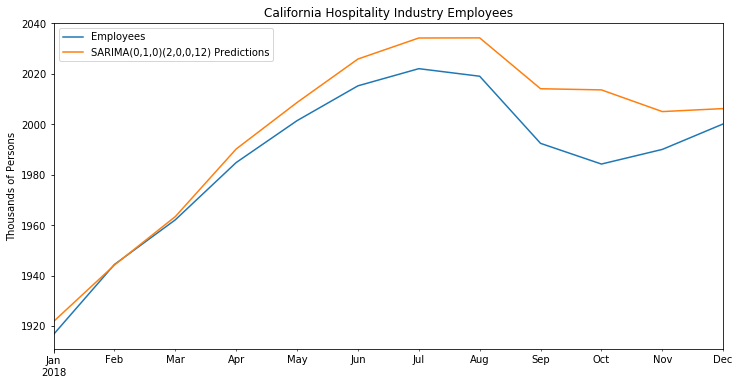

In [8]:
# DON'T WRITE HERE

### 10. Evaluate the Model using MSE and RMSE
You can run both from the same cell if you want.

In [19]:
error = mean_squared_error(test, predictions)
print(f'SARIMA(1,1,2)(1,0,1,12) MSE Error: {error:11.10}')
error = rmse(test, predictions)
print(f'SARIMA(1,1,2)(1,0,1,12) RMSE Error: {error:11.10}')

SARIMA(1,1,2)(1,0,1,12) MSE Error: 83.37860867
SARIMA(1,1,2)(1,0,1,12) RMSE Error: 9.131188787


In [9]:
# DON'T WRITE HERE

SARIMA(0,1,0)(2,0,0,12) MSE Error: 182.8506646
SARIMA(0,1,0)(2,0,0,12) RMSE Error: 13.52222854


### 11. Retrain the model on the full data and forecast one year into the future

In [20]:
mod = sm.tsa.statespace.SARIMAX(df['Employees'],
                                order=(1, 1, 2),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          Employees   No. Observations:                  348
Model:             SARIMAX(1, 1, 2)x(1, 0, 1, 12)   Log Likelihood               -1048.980
Date:                            Thu, 19 Dec 2019   AIC                           2109.960
Time:                                    17:02:21   BIC                           2132.791
Sample:                                01-01-1990   HQIC                          2119.065
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5224      0.424     -1.231      0.218      -1.354       0.310
ma.L1          2.9650      7.858   

In [10]:
# DON'T WRITE HERE

### 12. Plot the forecasted values alongside the original data
Optional: add a title and y-axis label.

In [21]:
fcast = results.predict(df.shape[0], df.shape[0]+11, typ='levels').rename('SARIMA(1,1,2)(1,0,1,12) Forecast')

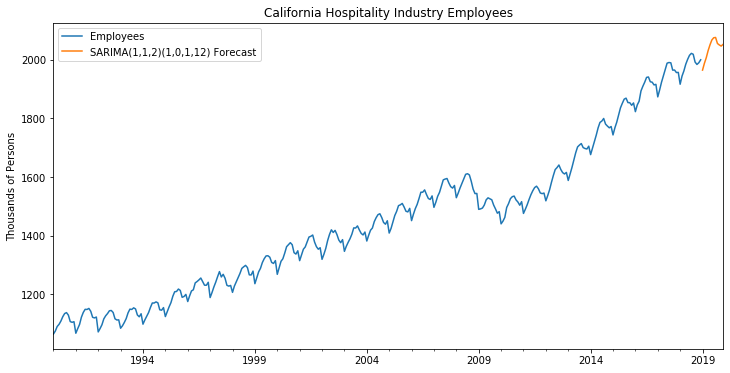

In [22]:
# Plot predictions against known values
title = 'California Hospitality Industry Employees'
ylabel='Thousands of Persons'
xlabel=''

ax = df['Employees'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

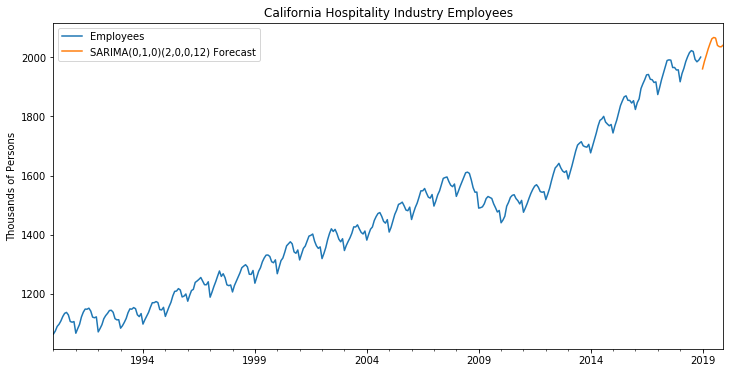

In [11]:
# DON'T WRITE HERE

# 13 Write down a list of potential datasets that you would like to use as exogenous variables to improve your prediction.  

In [89]:
# write list below
# weather
# tourist information

## Great job!